# MNIST modelling task

The task is to model a predictor/classifier for MNIST digit dataset. Make a complete workflow for at least two models and evaluate the results.

My solution includes:
- loading the MNIST dataset
- setup a pipeline for training
  - preprocessing the data e.g., normalization, scaling
  - train the models using GridSearchCV for parameter tuning
- evaluate the models using appropriate metrics e.g. accuracy


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings("ignore")  # To remove som annoying warnings apperaing occasionally

np.random.seed(42)  # Set the random seed for reproducibility

### Helper functions
Add some convenience functions

In [86]:
def SplitTestData(X, y, N, pTest=0.2, pVal=0.2):
    X_tf, X_tst, y_tf, y_tst = train_test_split(X[:N], y[:N], test_size=pTest)
    X_tr, X_val, y_tr, y_val = train_test_split(X_tf, y_tf, test_size=pVal)
    return X_tr, X_val, X_tst, y_tr, y_val, y_tst


def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()


def PlotMNIST(X, y, N, digits, min=0, max=1):
    R = len(digits)
    for d in range(R):
        Xs = X[y == digits[d]]
        for i in range(N):
            plt.subplot(R, N, d * N + i + 1)
            plt.imshow(
                Xs[i].reshape(28, 28), vmin=min, vmax=max, cmap=plt.get_cmap("gray_r")
            )
            plt.axis("off")
            plt.gca().set_box_aspect(1)
    plt.gcf().tight_layout()

In [87]:
# Create a wrapper for a generic estimator for easier parameter tuning
from sklearn.base import BaseEstimator
class MyEstimator(BaseEstimator):

    def __init__(self, classifier=None):
        self.classifier = classifier

    def fit(self, X, y=None, **kwargs):
        self.classifier.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.classifier.predict(X)

    def predict_proba(self, X):
        return self.classifier.predict_proba(X)

    def score(self, X, y):
        return self.classifier.score(X, y)

### Load and split dataset

In [88]:
mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

N = 2000 # Start using a moderate number of samples for time efficiency
(X_train, X_val, X_test, y_train, y_val, y_test) = SplitTestData(X, y, N)

### Exploratory Data Analysis

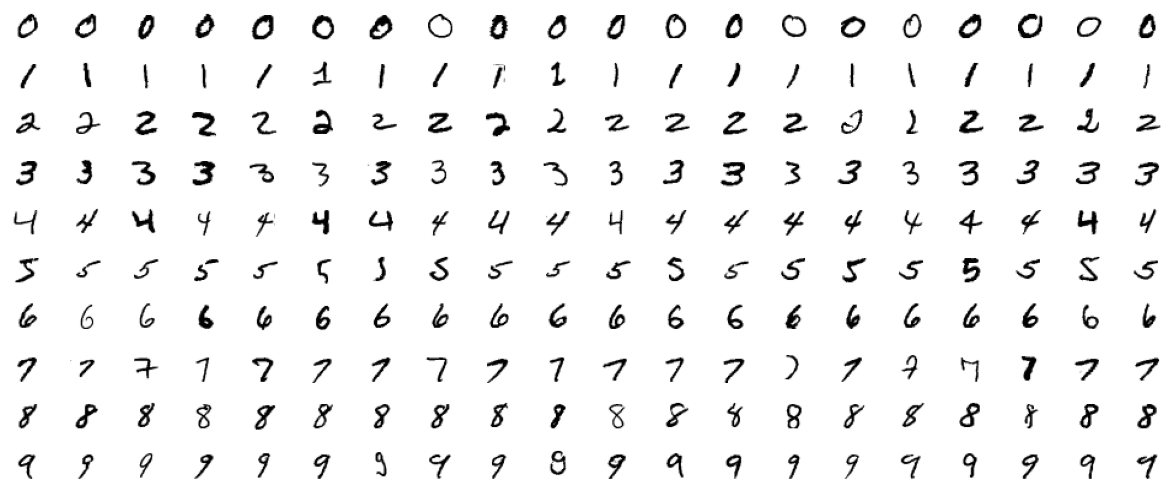

In [89]:
# Take a look at some of the digits of each class

plt.figure(1,figsize=(12,5))
PlotMNIST(X, y, N=20, digits=range(10), min=0, max=255)

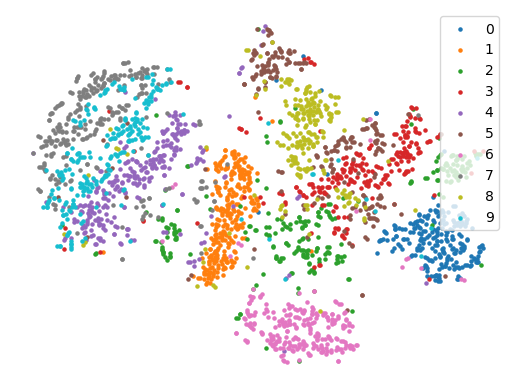

In [90]:
# Make a tSNE embedding to 2D and visualize
from sklearn.manifold import TSNE

N = 2500

# Standardizing the data.
scaler = StandardScaler()

Xtsne = scaler.fit_transform(X[:N])
Ytsne = y[:N]

# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111)

# tSNE
tsne = TSNE(n_components=2, init="pca", random_state=0, perplexity=30, max_iter=2000)
x_t = tsne.fit_transform(Xtsne)
x_df = pd.DataFrame(x_t)

result = pd.DataFrame(x_t, columns=["AX%i" % i for i in range(2)], index=x_df.index)

for i in range(10):
    ax.scatter(
        result.loc[Ytsne == i, "AX0"], result.loc[Ytsne == i, "AX1"], label=i, s=5
    )
plt.legend()
plt.axis("off")
plt.show()

Looks like the data give us a good chance to separate into classes.<br> 0, 1, 2 and 6 seems OK but [3-8-5] and [4-7-9] can be difficult since they overlap (at least when viewing in 2 dimensions) .

### Setup pipeline
Create the full pipeline with 'empty' estimators:

In [91]:
full_pipeline = Pipeline(steps=[("preScaler",'passthrough'), ("myModel", MyEstimator())])

# full_pipeline.get_params()

Setup a pipeline with:
- Preprocessing with StandardScaler() or Normalizer()
- SVC(poly) or RandomForestClassifier as the model to be tuned.
- Train the models using GridSearchCV for parameter tuning

In [92]:
# Try both StandardScaler and Normalizer for SVC, the RandomForestClassifier is OK without scaling
parameters = [
    {
        "preScaler": [Normalizer(), StandardScaler()],
        "myModel": [
            SVC(kernel="poly"),
        ],
        "myModel__C": [0.1, 1, 1.5],
        "myModel__gamma": [1, 10],
    },
    {
        "preScaler": ["passthrough"],
        "myModel": [
            RandomForestClassifier(n_estimators=100),
        ],
        "myModel__max_depth": [2, 5, 10, None],
        "myModel__min_samples_split": [2, 5, 10, 15],
    },
]

# Perform grid search cross-validation with 5-folds and accuracy as scoring.
gs = GridSearchCV(full_pipeline, parameters, cv=5, scoring="accuracy", n_jobs=-1)

# gs.get_params()

### Train the models
Train using a moderate number of data points to see the tendency of the model to generalize well (and to save time ...)

In [93]:
gs.fit(X_train, y_train)
print(f"Best params: \n\t{gs.best_params_}")
pd.DataFrame(gs.cv_results_)

Best params: 
	{'myModel': SVC(kernel='poly'), 'myModel__C': 0.1, 'myModel__gamma': 10, 'preScaler': Normalizer()}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_myModel,param_myModel__C,param_myModel__gamma,param_preScaler,param_myModel__max_depth,param_myModel__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.166505,0.331872,0.541738,0.019818,SVC(kernel='poly'),0.1,1.0,Normalizer(),NaN,NaN,"{'myModel': SVC(kernel='poly'), 'myModel__C': ...",0.843750,0.820312,0.855469,0.828125,0.824219,0.834375,0.013212,23
1,3.083630,0.295442,0.453137,0.015227,SVC(kernel='poly'),0.1,1.0,StandardScaler(),NaN,NaN,"{'myModel': SVC(kernel='poly'), 'myModel__C': ...",0.847656,0.878906,0.882812,0.828125,0.878906,0.863281,0.021679,14
2,1.710494,0.234736,0.482162,0.063524,SVC(kernel='poly'),0.1,10.0,Normalizer(),NaN,NaN,"{'myModel': SVC(kernel='poly'), 'myModel__C': ...",0.917969,0.941406,0.941406,0.890625,0.929688,0.924219,0.018912,1
3,2.802754,0.276417,0.446443,0.015523,SVC(kernel='poly'),0.1,10.0,StandardScaler(),NaN,NaN,"{'myModel': SVC(kernel='poly'), 'myModel__C': ...",0.847656,0.878906,0.882812,0.828125,0.878906,0.863281,0.021679,14
4,1.910774,0.131006,0.448102,0.026000,SVC(kernel='poly'),1.0,1.0,Normalizer(),NaN,NaN,"{'myModel': SVC(kernel='poly'), 'myModel__C': ...",0.914062,0.933594,0.933594,0.890625,0.921875,0.918750,0.015896,5
5,3.054044,0.349912,0.568993,0.182733,SVC(kernel='poly'),1.0,1.0,StandardScaler(),NaN,NaN,"{'myModel': SVC(kernel='poly'), 'myModel__C': ...",0.847656,0.878906,0.882812,0.828125,0.878906,0.863281,0.021679,14
6,2.108816,0.300306,0.551557,0.134562,SVC(kernel='poly'),1.0,10.0,Normalizer(),NaN,NaN,"{'myModel': SVC(kernel='poly'), 'myModel__C': ...",0.917969,0.941406,0.941406,0.890625,0.929688,0.924219,0.018912,1
7,2.911864,0.195591,0.480648,0.048229,SVC(kernel='poly'),1.0,10.0,StandardScaler(),NaN,NaN,"{'myModel': SVC(kernel='poly'), 'myModel__C': ...",0.847656,0.878906,0.882812,0.828125,0.878906,0.863281,0.021679,14
8,2.239895,0.430854,0.479662,0.062920,SVC(kernel='poly'),1.5,1.0,Normalizer(),NaN,NaN,"{'myModel': SVC(kernel='poly'), 'myModel__C': ...",0.917969,0.941406,0.937500,0.890625,0.921875,0.921875,0.017986,4
9,3.186737,0.364829,0.502703,0.017981,SVC(kernel='poly'),1.5,1.0,StandardScaler(),NaN,NaN,"{'myModel': SVC(kernel='poly'), 'myModel__C': ...",0.847656,0.878906,0.882812,0.828125,0.878906,0.863281,0.021679,14


In [94]:
print(f"Best model:\n\t{gs.best_params_}")
gs.best_estimator_.fit(X_train, y_train)
sc = gs.best_estimator_.score(X_test, y_test)
print(f"Score:\n\t{sc}")

Best model:
	{'myModel': SVC(kernel='poly'), 'myModel__C': 0.1, 'myModel__gamma': 10, 'preScaler': Normalizer()}
Score:
	0.935


In [95]:
# Finetune/retrain above model on larger dataset
(X_train, X_val, X_test, y_train, y_val, y_test) = SplitTestData(X, y, 25000)
gs.best_estimator_.fit(X_train, y_train)
sc = gs.best_estimator_.score(X_test, y_test)
print(f"Score:\n\t{sc}")


Score:
	0.9806


### Analysis of the model

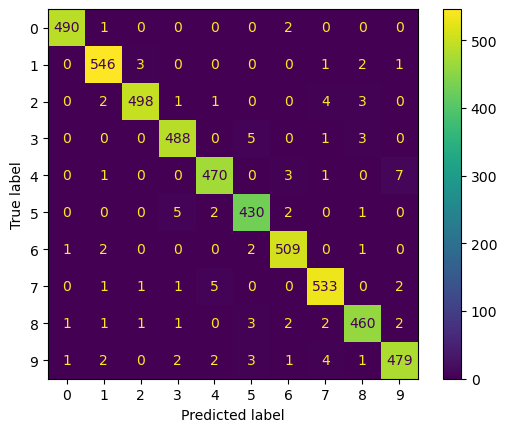

In [96]:
y_pred = gs.best_estimator_.predict(X_test)
display_confusion_matrix(y_test, y_pred )

In [97]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       493
           1       0.98      0.99      0.98       553
           2       0.99      0.98      0.98       509
           3       0.98      0.98      0.98       497
           4       0.98      0.98      0.98       482
           5       0.97      0.98      0.97       440
           6       0.98      0.99      0.98       515
           7       0.98      0.98      0.98       543
           8       0.98      0.97      0.97       473
           9       0.98      0.97      0.97       495

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



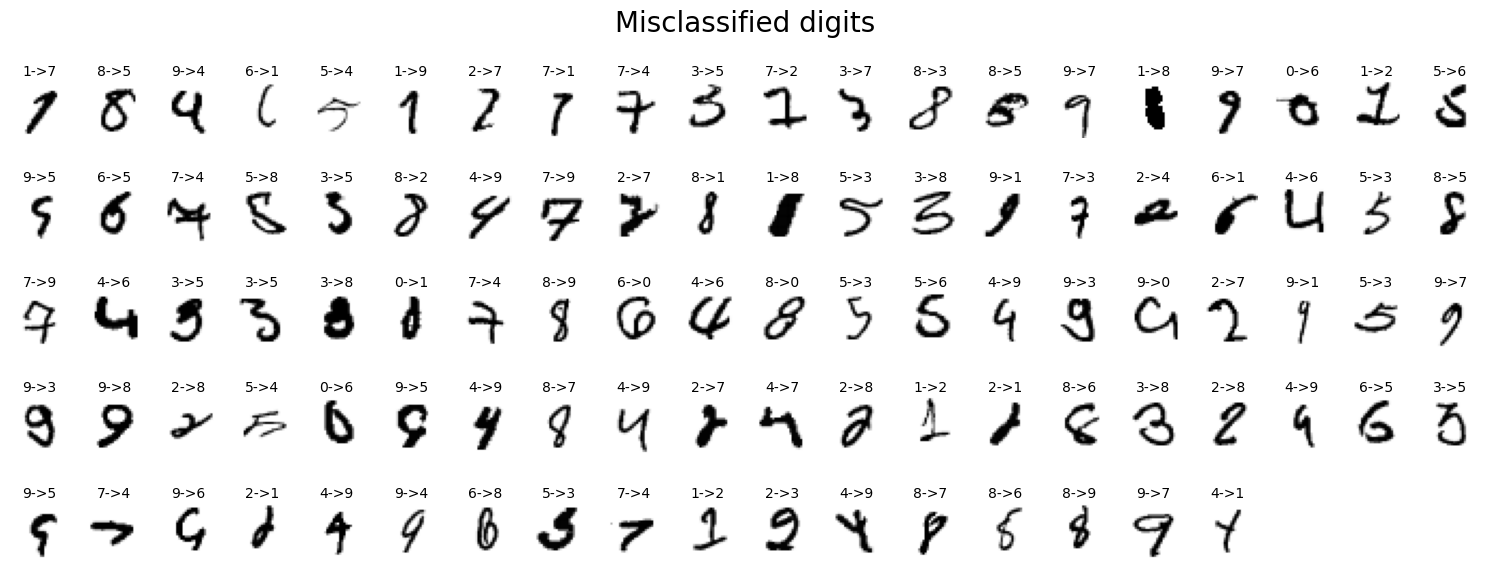

In [ ]:
# Plot the 100 first misclassified digits
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["figure.titlesize"] = 20
fig = plt.figure(figsize=(15, 6))
yy = y_test[y_test != y_pred]
zz = y_pred[y_test != y_pred]
xx = X_test[y_test != y_pred]
R = len(yy)
for i in range(min(R,100)):
    plt.subplot(5, 20, i + 1)
    plt.imshow(
        xx[i].reshape(28, 28), cmap=plt.get_cmap("gray_r")
    )
    plt.axis("off")
    plt.title(f"{yy[i]}->{zz[i]}", pad=0)
    plt.gca().set_box_aspect(1)
plt.gcf().suptitle("Misclassified digits")
plt.gcf().tight_layout()


### Summary

- The model achieved an accuracy of about 98% on the test dataset.
- The confusion matrix shows that the model performs well on the majority of classes.
- The misclassified digits can be seen in the plot, highlighting the model's ability to generalize well. 
- The most misclassified digits often have similar patterns or appearances which may be visible already in the tSNE plot.
- The worst-performing digits in the F1 score was 5, 8 and 9
- The model could be further improved by increasing the dataset size or exploring other models.